<a href="https://colab.research.google.com/github/xu62u4u6/IMDB/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as os_join
plt.style.use("seaborn")

<ipython-input-1-8674f51a0f26>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/code/資料分析/IMDB")

Mounted at /content/drive


In [ ]:
# can download data from https://datasets.imdbws.com/
!cd data/
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!wget https://datasets.imdbws.com/title.ratings.tsv.gz

In [3]:
title_basics = pd.read_csv("data/title.basics.tsv.gz", sep="\t")
title_ratings = pd.read_csv("data/title.ratings.tsv.gz", sep="\t")

<ipython-input-3-304a3e079f32>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv("data/title.basics.tsv.gz", sep="\t")


In [4]:
df = pd.merge(title_basics, title_ratings, on='tconst')

In [ ]:
# 將tconst中tt去除，並設為index
df.index = df.tconst.apply(lambda x: int(x.split("tt")[1]))
df = df.drop("tconst", axis=1)
df.index.name = "ID"
df.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
ID,,,,,,,,,,
1,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1664
2,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.1,206
3,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1382
4,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.2,123
5,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2168


In [ ]:
# 查看各類別數量
gb = df.groupby("titleType")
gb.size()

titleType
audiobook            1
movie           256557
radioSeries          1
short           127301
tvEpisode       503143
tvMiniSeries     10932
tvMovie          42131
tvSeries         72325
tvShort           5914
tvSpecial         9288
video            59211
videoGame        11487
dtype: int64

In [ ]:
# 種類太多，這邊只取movie
df = df[df.titleType == "movie"]

In [ ]:
df.numVotes.describe().round(2) # 查看投票人數分布狀況，可以發現最大值大得誇張

count     256557.00
mean        3306.75
std        31764.15
min            5.00
25%           14.00
50%           48.00
75%          261.00
max      2312613.00
Name: numVotes, dtype: float64

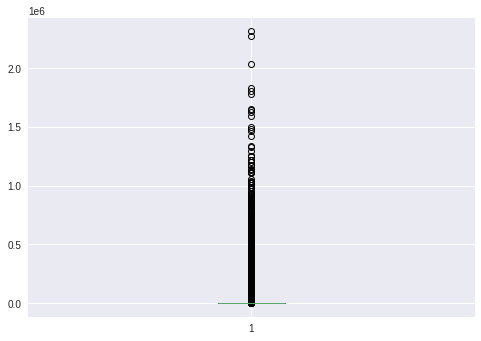

In [ ]:
plt.boxplot(df.numVotes)
plt.show()

In [ ]:
df[df.numVotes == df.numVotes.max()]  # 最高票果不其然是刺激1995

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
ID,,,,,,,,,,
111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2312613


In [ ]:
df.averageRating.describe().round(2) # 平均得分的分布

count    256557.00
mean          6.13
std           1.33
min           1.00
25%           5.40
50%           6.30
75%           7.00
max          10.00
Name: averageRating, dtype: float64

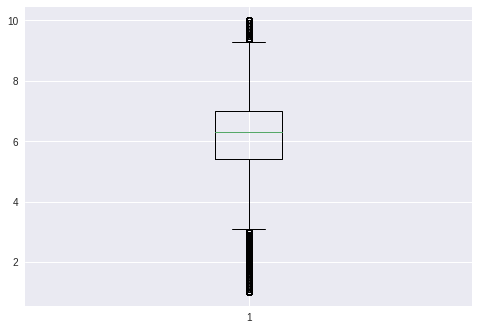

In [ ]:
plt.boxplot(df.averageRating)
plt.show()

In [ ]:
df = df[df.startYear != "\\N"] # 去除沒有年份資料

In [ ]:
df.startYear = df.startYear.astype(np.int64) # 年份轉成int

In [ ]:
df = df[df.startYear > 1970] # 去除1970年以前的片，因投票和評價易失真

In [ ]:
df.startYear.describe()

count    203400.000000
mean       2002.968668
std          13.930035
min        1971.000000
25%        1993.000000
50%        2008.000000
75%        2014.000000
max        2021.000000
Name: startYear, dtype: float64

In [ ]:
df.averageRating.describe()

count    203400.000000
mean          6.131414
std           1.394841
min           1.000000
25%           5.300000
50%           6.300000
75%           7.100000
max          10.000000
Name: averageRating, dtype: float64

In [ ]:
df[df.averageRating == "\\N"]

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
ID,,,,,,,,,,


In [ ]:
df[df.numVotes == "\\N"]

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
ID,,,,,,,,,,


### 分數設計
透過投票人數和評分來算分<BR>
由於投票人數過於懸殊，決定取log並正規化壓到0~1之間<BR>
而分數則進行標準化。<BR><BR>
$score=\frac{numVotes(log10)}{max(numVotes(log10)}\times\frac{averageRating-mean(averageRating))}{std(averageRating)}$

In [ ]:
df.loc[:, "score"] = (np.log10(df.numVotes)/ np.log10(df.numVotes).max()) * \
            ((df.averageRating - df.averageRating.mean())/df.averageRating.std())

In [ ]:
df[df.score >= (df.score.mean() + df.score.std() * 2)] #+2標準差的

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
ID,,,,,,,,,,,
65670,movie,Twelve Chairs,12 stulev,0,1971,\N,159,"Adventure,Comedy,Crime",8.3,5784,0.919094
66078,movie,Michael the Brave,Mihai Viteazul,0,1971,\N,203,"Action,Biography,Drama",8.4,6067,0.966778
66498,movie,The Ear,Ucho,0,1990,\N,94,"Drama,Thriller",7.8,2469,0.637689
66730,movie,10 Rillington Place,10 Rillington Place,0,1971,\N,111,"Biography,Crime,Drama",7.6,7479,0.640884
66758,movie,Amar Prem,Amar Prem,0,1972,\N,143,"Drama,Musical,Romance",8.2,1507,0.740595
...,...,...,...,...,...,...,...,...,...,...,...
9866708,movie,Wild Karnataka,Wild Karnataka,0,2020,\N,53,"Documentary,Family",8.8,437,0.793784
9886872,movie,Munthiri Monchan,Munthiri Monchan,0,2019,\N,130,"Comedy,Romance",8.1,996,0.664908
9900782,movie,Kaithi,Kaithi,0,2019,\N,145,"Action,Thriller",8.5,10441,1.072302


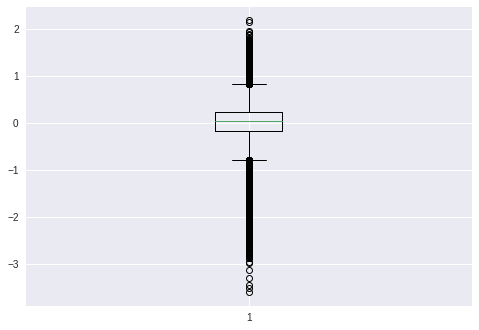

In [ ]:
plt.boxplot(df.score)
plt.show()

In [ ]:
df.sort_values(by="score", ascending=False)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
ID,,,,,,,,,,,
111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2312613,2.271646
68646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1596491,2.144321
468569,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",9.0,2275200,2.054279
71562,movie,The Godfather: Part II,The Godfather: Part II,0,1974,\N,202,"Crime,Drama",9.0,1115253,1.954216
110912,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama",8.9,1804679,1.951284
...,...,...,...,...,...,...,...,...,...,...,...
1213644,movie,Disaster Movie,Disaster Movie,0,2008,\N,87,Comedy,1.9,86735,-2.353921
1702443,movie,Justin Bieber: Never Say Never,Justin Bieber: Never Say Never,0,2011,\N,105,"Documentary,Music",1.6,75063,-2.488768
5988370,movie,Reis,Reis,0,2017,\N,108,"Biography,Drama",1.4,72265,-2.589820


In [ ]:
df.score.describe()

count    203400.000000
mean         -0.008024
std           0.314451
min          -2.712072
25%          -0.162012
50%           0.025570
75%           0.176703
max           2.271646
Name: score, dtype: float64

In [ ]:
df[(df.score > 1.8)].sort_values(by="score", ascending=False) # 篩出最高分的幾部，大概都是鄉民公認神片了

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,score
ID,,,,,,,,,,,
111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama,9.3,2312613,2.271646
68646,movie,The Godfather,The Godfather,0,1972,\N,175,"Crime,Drama",9.2,1596491,2.144321
468569,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama",9.0,2275200,2.054279
71562,movie,The Godfather: Part II,The Godfather: Part II,0,1974,\N,202,"Crime,Drama",9.0,1115253,1.954216
110912,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama",8.9,1804679,1.951284
167260,movie,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,0,2003,\N,201,"Action,Adventure,Drama",8.9,1623819,1.936980
1375666,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi",8.8,2037541,1.896649
108052,movie,Schindler's List,Schindler's List,0,1993,\N,195,"Biography,Drama,History",8.9,1199585,1.895965
137523,movie,Fight Club,Fight Club,0,1999,\N,139,Drama,8.8,1832224,1.882782


In [ ]:
#最後選出大於1.2的存檔，encoding是windows下容易出錯才存這個格式
df[(df.score > 1.2)].to_csv("top206.csv", encoding="utf_8_sig")